In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def get_dt(domain):
    '''
    Get the average distance between values in an ordered list.
    
    ARGUMENT: domain -- list of equally-spaced values
    RETURN: dx -- spacing between points in the domain list
    '''
    dt = (domain[-1] - domain[0]) / len(domain)
    return dt

def integrate(fn_list, dx, intercept=0):
    '''
    Numerically integrate a function (represented by a list of values 
    evaluating that function over a domain) using a Riemannian sum. 
    Use the initial condition that the function first crosses the 
    vertical axis at a value set by the "intercept".
    
    ARGUMENTS:
    fn_list -- list of values evaluating a function over a domain
    dx -- spacing between domain values
    intercept -- intercept of the integrated function with the vertical axis
    
    RETURNS:
    integral -- array of values evaluating the integral over the domain
    '''
    array = np.array(fn_list) * dx
    integral = [array[0]]
    for val in array[1:]:
        integral.append(integral[-1] + val)
    integral += intercept * np.ones(len(integral))
    return integral

def n_integ(fn_list, dx, n, get_all=False):
    '''
    Perform the integration function n times with the default initial
    conditions.
    
    ARGUMENTS:
    fn_list -- list of values evaluating a function over a domain
    dx -- spacing between domain values
    n -- number of times to perform the integration
    get_all -- boolean; specify whether to return all integrals (or just final)
    
    RETURNS:
    integ_dict -- if get_all; dictionary {1: [], ... , n: []} of integral arrays
    integ_dict[n] -- if not get_all; array of values from final integration
    
    '''
    integ_dict = {}
    integ_dict[1] = integrate(fn_list, dx)
    for k in range(1, n):
        integ_dict[k + 1] = integrate(integ_dict[k], dx)
    if get_all:
        return integ_dict
    else:
        return integ_dict[n]

In [80]:
### --------- Theoretical Equations of Motion --------- ###
'''

alpha: angular acceleration of rod (= F * s / I)
    F: magnitude of force constantly applied to rod
    s: 1/2 * (length of rod)
    I: moment of inertia about center of rod
    m: mass of rod

      theta(t) = 1/2 * alpha * t^2
    m * a_x(t) = -F * sin(theta(t))
    m * a_y(t) =  F * cos(theta(t))
   
'''
### ------------- Numerical coefficients  ------------- ###

A = 1   # A = 1/2 * alpha
B = 1     # B = F/m
s = 1

### ---------- Numerical Equations of Motion ---------- ###

# Computation domain
t = np.linspace(0, 30, 10000)
dt = get_dt(t)

# Angular orientation of rod 
theta = A * t ** 2   

# Acceleration of rod COM
a_x = -B * np.sin(theta)
a_y = B * np.cos(theta)

# Velocity of rod COM
v_x = integrate(a_x, dx)
v_y = integrate(a_y, dx)

# Speed of rod COM
v = (np.array(x_1) ** 2 + np.array(y_1) ** 2) ** 0.5

# Position of rod end relative to COM
x_rot = s * np.cos(theta)
y_rot = s * np.sin(theta)

# Position of rod end relative to initial frame of no motion
x_edge = x + x_rot
y_edge = y + y_rot

# Speed of rod end relative to initial frame of no motion
v_tot = (x_edge ** 2 + y_edge ** 2) ** 0.5

# dct = {'theta': theta, 
#        'a_x': a_x, 
#        'a_y': a_y, 
#        'v_x': v_x,
#        'v_y': v_y,
#        'v': v,
#        'v_tot' : v_tot,
#        'x_edge': x_edge,
#        'y_edge': y_edge}

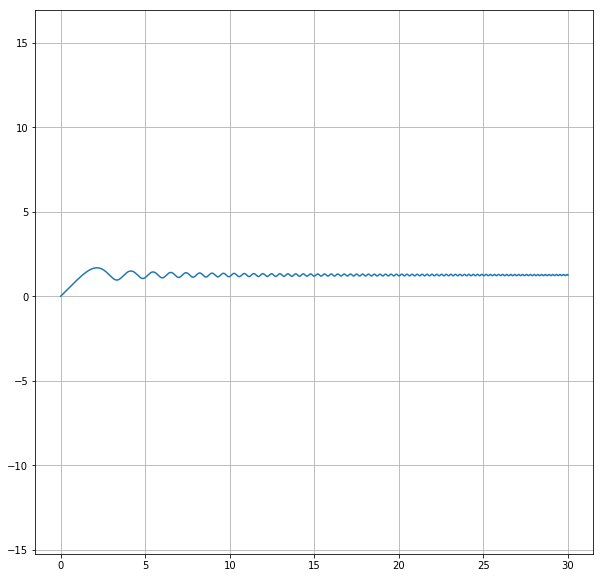

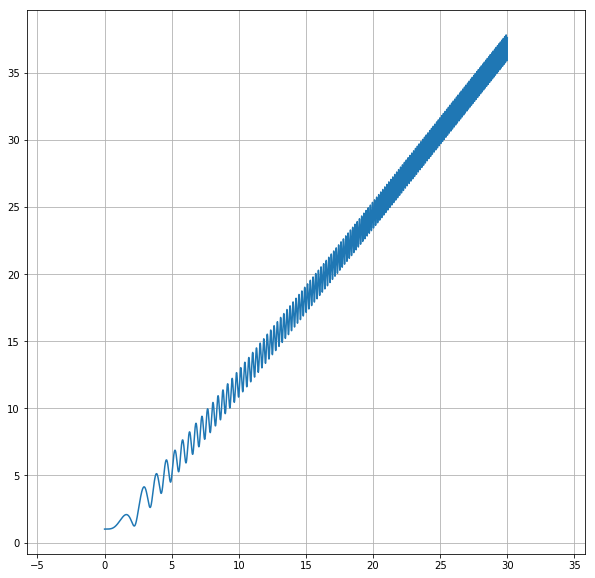

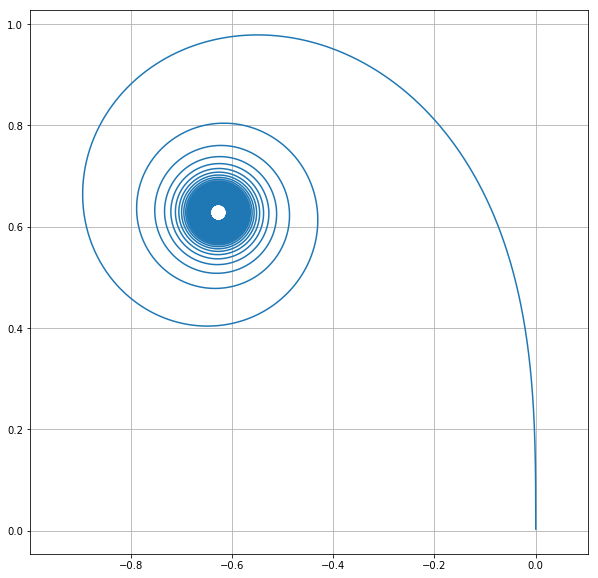

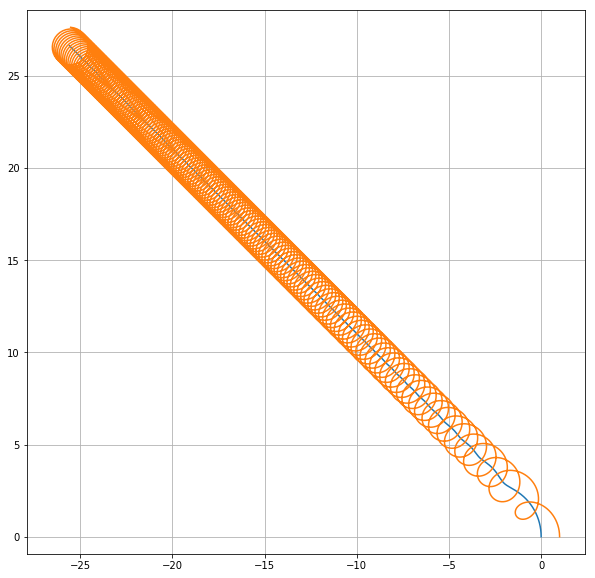

In [81]:
### ---------------------- Plots ---------------------- ###

def make_plot(fn_list):
    '''
    Make a nicely formatted x-y plot of an arbitary number of functions.
    
    ARGUMENT: fn_list -- list of list of [x, y] pairs of arrays
    '''
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    plt.axis('equal')
    ax.grid(True)
    
    for item in fn_list:
        plt.plot(item[0], item[1])
    
    plt.show()

make_plot([[t, v]])
make_plot([[t, v_tot]])
make_plot([[v_x, v_y]])
make_plot([[x, y], [x_edge, y_edge]])